In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
class CFG:
    sequence_length = 1024
    vocab_size = 10000

In [ ]:
negative_df = pd.read_csv("/content/True.csv")
negative_df["fake"] = 0.0
positive_df = pd.read_csv("/content/Fake.csv")
positive_df["fake"] = 1.0
train_df = pd.concat([negative_df, positive_df])
train_df.head()

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0.0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0.0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0.0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0.0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0.0


<Axes: xlabel='fake'>

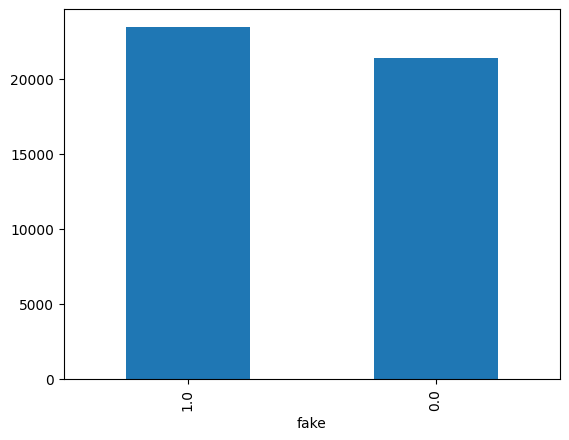

In [ ]:
train_df.fake.value_counts().plot(kind="bar")

In [ ]:
train_df["title_length"] = train_df["title"].apply(lambda title: len(title.split(" ")))
train_df["text_length"] = train_df["text"].apply(lambda text: len(text.split(" ")))

In [ ]:
train_df[["title_length", "text_length"]].describe()

,title_length,text_length
count,44898.000000,44898.000000
mean,12.657245,415.760412
std,4.170713,361.648003
min,1.000000,1.000000
25%,10.000000,208.000000
50%,12.000000,371.000000
75%,15.000000,525.000000
max,45.000000,8436.000000


<Axes: ylabel='Frequency'>

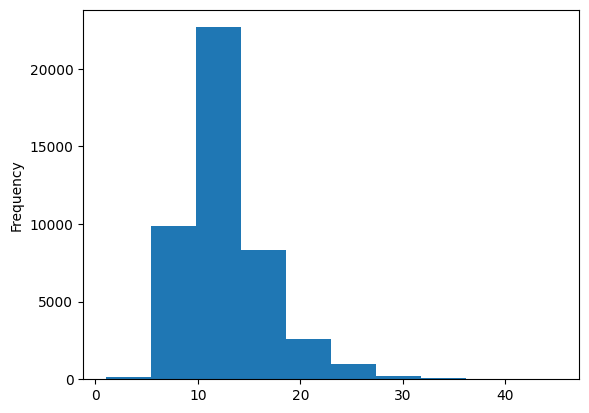

In [ ]:
train_df["title_length"].plot(kind="hist")

<Axes: ylabel='Frequency'>

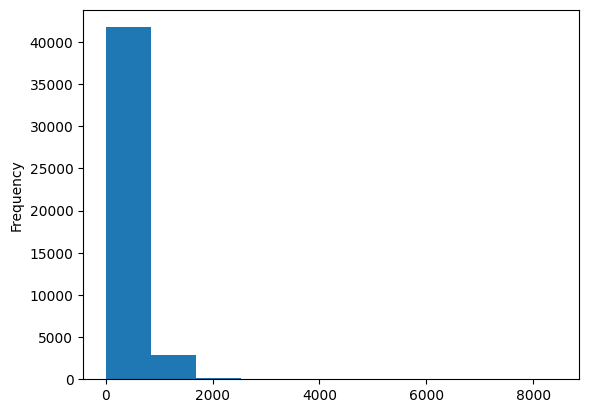

In [ ]:
train_df["text_length"].plot(kind="hist")

In [ ]:
train_data, valid_data = train_test_split(train_df, test_size=0.2, stratify=train_df["fake"], random_state=42)
train_data.shape, valid_data.shape

((35918, 7), (8980, 7))

In [ ]:
def create_dataset(dataframe, shuffle=True):
    # Create a TensorFlow dataset from the text and fake columns of the dataframe
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["text"], dataframe["fake"]))
    if shuffle:
         # Shuffle the dataset if the shuffle parameter is True
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    # Batch the dataset into smaller batches of size 256
    dataset = dataset.batch(256).cache().prefetch(tf.data.AUTOTUNE)
    # Prefetch the next batch of data to further optimize training
    return dataset

In [ ]:
train_ds = create_dataset(train_data)
valid_ds = create_dataset(valid_data, shuffle=False)

In [ ]:
# Create a TextVectorization layer with specified parameters
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=CFG.vocab_size,
    output_sequence_length=CFG.sequence_length,
    pad_to_max_tokens=True
)
# Adapt the TextVectorization layer to the training data
vectorizer.adapt(train_df["text"], batch_size=1024)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 1024)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 1024, 64)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1024, 128)           │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 748,321 (2.85 MB)

 Trainable params: 748,321 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

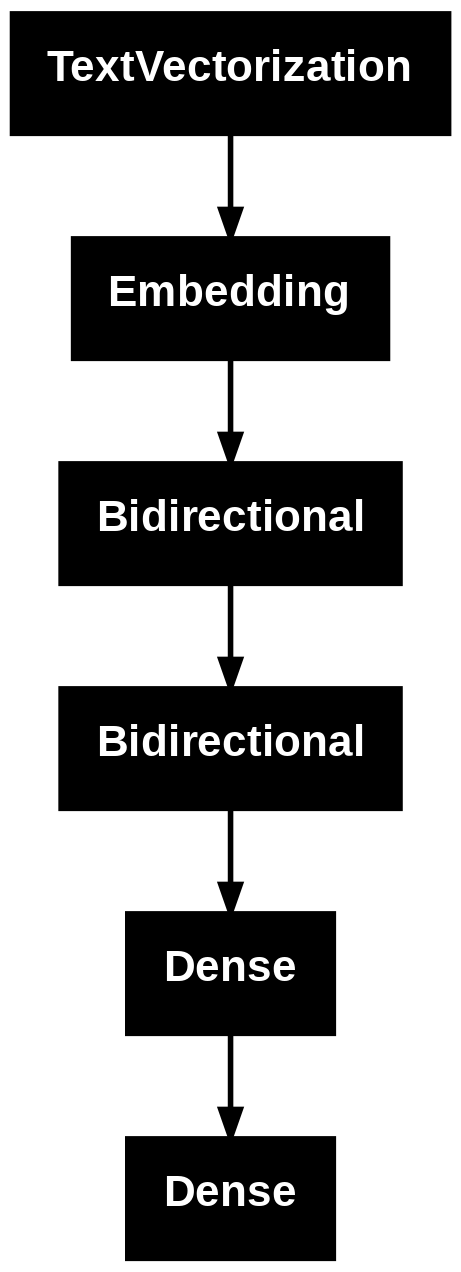

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    vectorizer,
    tf.keras.layers.Embedding(
        input_dim=CFG.vocab_size,
        output_dim=64,
        input_length=CFG.sequence_length,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc")
    ]
)
model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
file_path = "model.tf"
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            file_path,
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
    ]
)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=model.tf

In [ ]:
file_path = "model.keras"  # Change the file extension to .keras
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            file_path,
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
    ]
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1992s 14s/step - accuracy: 0.9525 - auc: 0.9816 - loss: 0.2719 - val_accuracy: 0.9993 - val_auc: 0.9998 - val_loss: 0.0144
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1934s 14s/step - accuracy: 0.9989 - auc: 0.9999 - loss: 0.0142 - val_accuracy: 0.9997 - val_auc: 0.9998 - val_loss: 0.0114
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1900s 13s/step - accuracy: 0.9997 - auc: 0.9999 - loss: 0.0100 - val_accuracy: 0.9983 - val_auc: 0.9996 - val_loss: 0.0143
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1901s 13s/step - accuracy: 0.9998 - auc: 0.9999 - loss: 0.0083 - val_accuracy: 0.9996 - val_auc: 0.9998 - val_loss: 0.0087
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1881s 13s/step - accuracy: 0.9998 - auc: 0.9999 - loss: 0.0064 - val_accuracy: 0.9997 - val_auc: 0.9998 - val_loss: 0.0073
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1880s 13s/step - accuracy: 0.9997 - auc: 1.0000 - loss: 0.0053 - val_accuracy: 0.9993 - val_auc: 0.9995 - val_loss: 0.0079
Epoch 7/10
141/141 ━━━

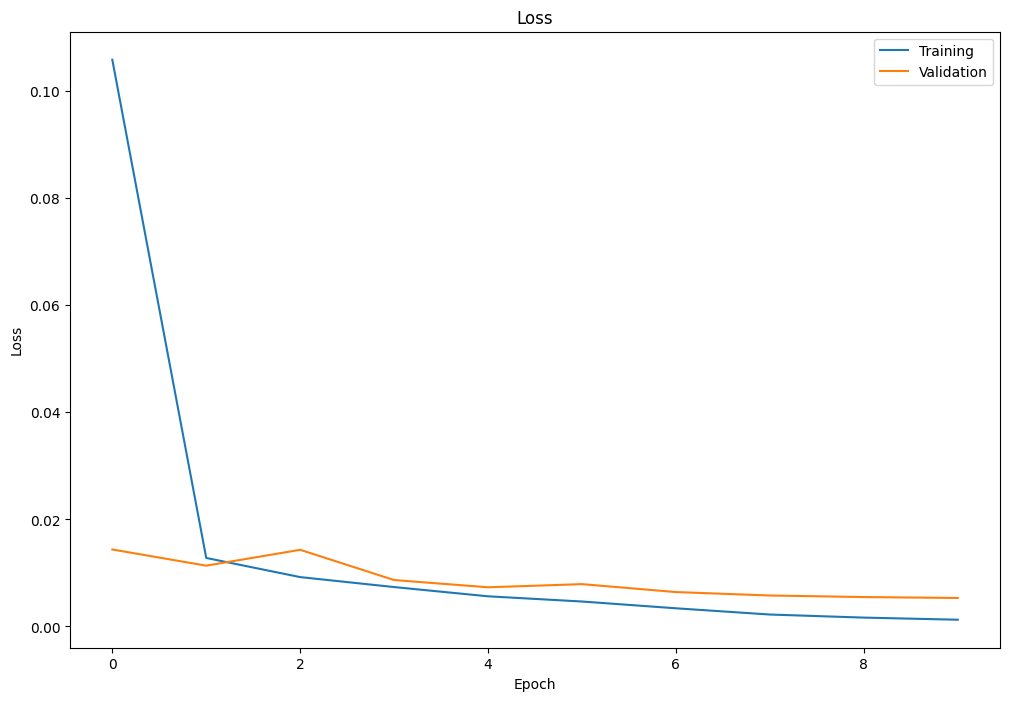

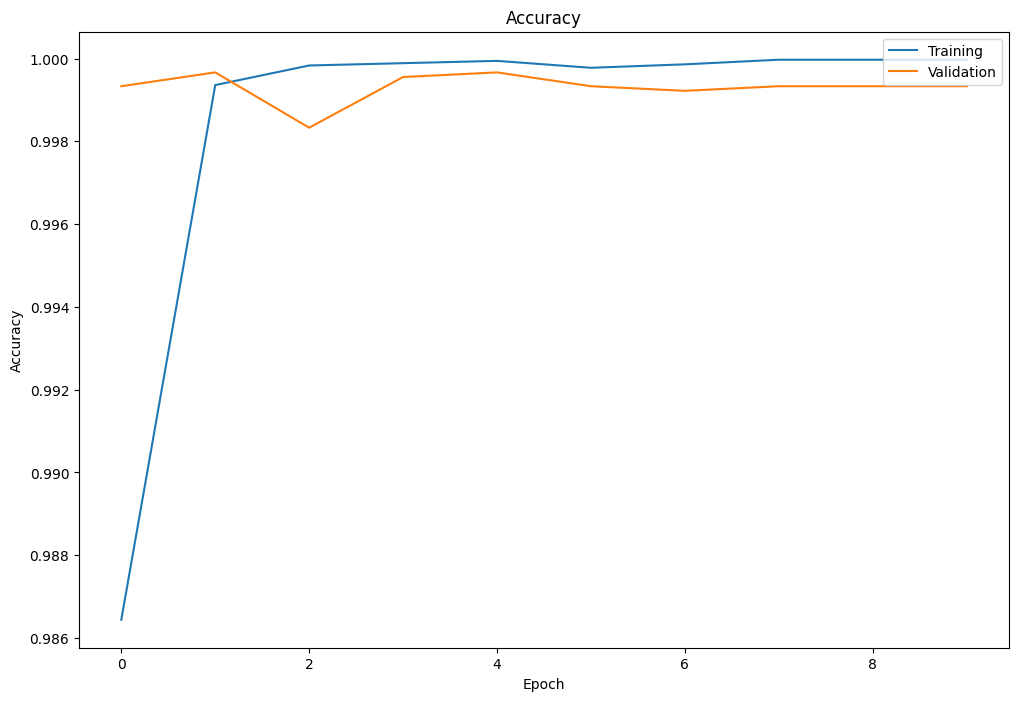

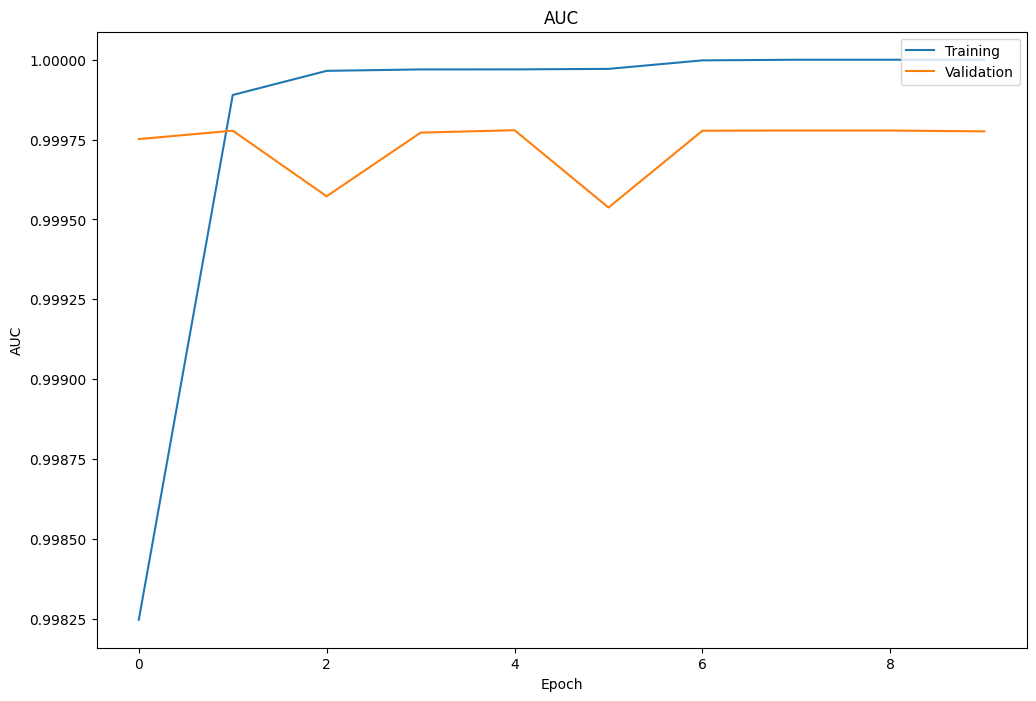

In [ ]:
def plot_learning_curve(history):
  plt.figure(figsize=(12, 8))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  plt.figure(figsize=(12, 8))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  plt.figure(figsize=(12, 8))
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('AUC')
  plt.ylabel('AUC')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()
plot_learning_curve(history)